In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pmd
from statsmodels.tsa.api import DynamicFactorMQ
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [15]:
# Load the dataset
df = pd.read_csv("./BTC.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df['Vol.'] = df['Vol.'].str.replace('K', 'e3')
df['Vol.'] = df['Vol.'].str.replace('M', 'e6')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df

,Price,Vol.
Date,,
2017-12-01,10861.5,131920.0
2017-12-02,10912.7,86830.0
2017-12-03,11246.2,122130.0
2017-12-04,11623.9,93170.0
2017-12-05,11667.1,89690.0
...,...,...
2023-03-28,27262.2,94160.0
2023-03-29,28350.4,109320.0
2023-03-30,28029.5,122510.0


### 2. Split the data into training, test and validate sets

In [16]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1363, 2)
Test shape: (292, 2)
Validate shape: (293, 2)


In [17]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1168, 2)
Test shape: (389, 2)
Validate shape: (391, 2)


In [18]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1363, 2)
Test shape: (389, 2)
Validate shape: (196, 2)


## 3. Perform Dynamic Factor Model

### 3.1 Build and fit train data into Dynamic Factor Model

In [19]:
df_model = DynamicFactorMQ(endog=train_data, factors=2, factor_orders=1, idiosyncratic_ar1=True)
df_model_fit = df_model.fit(maxiter=100, disp=True)
df_model_fit.summary()

EM start iterations, llf=-3278.7
EM iteration 2, llf=-1818.7, convergence criterion=0.57282
EM iteration 3, llf=-1818.7, convergence criterion=1.1107e-07
EM converged at iteration 3, llf=-1818.7, convergence criterion=1.1107e-07 < tolerance=1e-06


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:           ['Price', 'Vol.']   No. Observations:                 1363
Model:                Dynamic Factor Model   Log Likelihood               -1818.739
                   + 2 factors in 2 blocks   AIC                           3661.479
                     + AR(1) idiosyncratic   BIC                           3724.088
Date:                     Fri, 16 Jun 2023   HQIC                          3684.915
Time:                             14:45:31   EM Iterations                        3
Sample:                         12-01-2017                                         
                              - 08-24-2021                                         
Covariance Type:              Not computed                                         
                          Observation equation:                           
==========================================================================
Factor loadings:          0          1    idiosyncratic: AR(1)        var.
--------------------------------------------------------------------------
           Price      -0.71       0.44                   -0.00        0.00
            Vol.       0.71       0.44                   -0.00        0.00
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.90              0.23
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.85              0.56
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [20]:
def evaluate_dynamic_factor_model(data):
    pred = df_model_fit.predict(start=data.index[0], end=data.index[len(data)-1])
    data = data[features]
    pred = pred[features]
    mse = mean_squared_error(data, pred)
    mae = mean_absolute_error(data, pred)
    mape = mean_absolute_percentage_error(data, pred)
    rmse = mean_squared_error(data, pred, squared=False)
    return pred, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [21]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_dynamic_factor_model(val_data)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data:                    Price
2022-09-18  14987.045708
2022-09-19  14987.045708
2022-09-20  14987.045708
2022-09-21  14987.045708
2022-09-22  14987.045708
...                  ...
2023-03-28  14987.045708
2023-03-29  14987.045708
2023-03-30  14987.045708
2023-03-31  14987.045708
2023-04-01  14987.045708

[196 rows x 1 columns]


### 3.3 Evaluate on Test data

In [22]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_dynamic_factor_model(test_data)
print("Price predict on test data:", y_pred_test)

Price predict on test data:                    Price
2021-08-25  43834.256210
2021-08-26  40437.836871
2021-08-27  37462.055273
2021-08-28  34852.246287
2021-08-29  32561.151608
...                  ...
2022-09-13  14987.045708
2022-09-14  14987.045708
2022-09-15  14987.045708
2022-09-16  14987.045708
2022-09-17  14987.045708

[389 rows x 1 columns]


### 3.4 Predict price for the next 30 days

In [23]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

y_next_30_days = df_model_fit.predict(start=date_range[0], end=date_range[len(date_range)-1])[features]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
                   Price
2023-04-01  14987.045708
2023-04-02  14987.045708
2023-04-03  14987.045708
2023-04-04  14987.045708
2023-04-05  14987.045708
2023-04-06  14987.045708
2023-04-07  14987.045708
2023-04-08  14987.045708
2023-04-09  14987.045708
2023-04-10  14987.045708
2023-04-11  14987.045708
2023-04-12  14987.045708
2023-04-13  14987.045708
2023-04-14  14987.045708
2023-04-15  14987.045708
2023-04-16  14987.045708
2023-04-17  14987.045708
2023-04-18  14987.045708
2023-04-19  14987.045708
2023-04-20  14987.045708
2023-04-21  14987.045708
2023-04-22  14987.045708
2023-04-23  14987.045708
2023-04-24  14987.045708
2023-04-25  14987.045708
2023-04-26  14987.045708
2023-04-27  14987.045708
2023-04-28  14987.045708
2023-04-29  14987.045708
2023-04-30  14987.045708


### 4.  Evaluate accuracy validate, test data

In [24]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE           MAE      MAPE          RMSE
Validate  4.049871e+07   5406.496639  0.246205   6363.859602
Test      7.225787e+08  23514.135095  0.549881  26880.824544


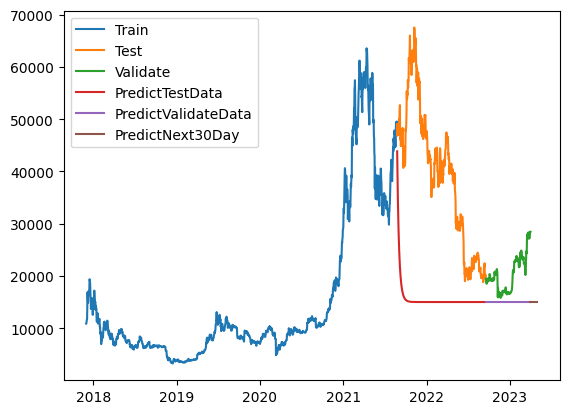

In [25]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()